# Modelos predictivos

Esta entrega consiste en elaborar un modelo predictivo que presente un desempeño superior al 80%.


## Carga de las librerías


In [587]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, datetime

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report
from sklearn.feature_selection import SelectKBest 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections import Counter

## Carga de los datos


In [588]:
df_weather = pd.read_csv('weatherAUS.csv')
df_weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [589]:
print("El dataset presenta {0} observaciones considerando {1} variables".format(df_weather.shape[0], df_weather.shape[1]))

El dataset presenta 142193 observaciones considerando 24 variables


In [590]:
df_weather.columns = df_weather.columns.str.lower()
df_weather.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation',
       'sunshine', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm',
       'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm',
       'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am',
       'temp3pm', 'raintoday', 'risk_mm', 'raintomorrow'],
      dtype='object')

## Modelo predictivo


- Con los modelos predictivos a realizar, se útilizará como variable a predecir "raintomorrow"
- Se realizarán 4 modelos
- Se tomarán como variables independiente todo el dataset (sin contar la variable a predecir), esto para un modelo de NaiveBayes y de DecisionTree
- Para los siguientes dos modelos se tomarán como variables indepentienes las que el arbol de decisión les de inportancia


In [591]:
df_weather['raintomorrow'].unique()

array(['No', 'Yes'], dtype=object)

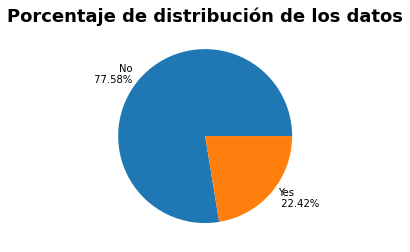

In [592]:
clases = np.array([df_weather[df_weather.raintomorrow == 'No'].shape[0], 
                   df_weather[df_weather.raintomorrow == 'Yes'].shape[0]])

labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No\n ' + labels[0]
labels[1] = 'Yes\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de distribución de los datos', fontsize=18, fontweight="bold")
plt.show()

In [593]:
df_weather.groupby('raintomorrow').size()

raintomorrow
No     110316
Yes     31877
dtype: int64

- 77.58% (110.316) indican que No llueve el día de mañana
- 2.42% (31.877) indican que Si llueve el día de mañana
- Se observa que existe una gran dispersión de los datos, en donde 'No' presenta la mayor cantidad de ellos


In [594]:
df_weather_t = df_weather.copy()
df_weather_t = df_weather_t.drop(['risk_mm'], axis=1)

+ Se tomó la decisión de eliminar la variable "risk_mm", esto porque, al realizar los modelo de DecisionTree, este arrojaba SOLO esta variable con importancia, a un nivel de 1.0, obteniendo una precision del 100%

### Limpieza de nulos


In [595]:
for i in df_weather_t:
    if df_weather_t[i].isnull().sum() > 0:
        print("La columna {0} presenta una cantidad de {1} valores nulos".format(df_weather_t[i].name, df_weather_t[i].isnull().sum()))

La columna mintemp presenta una cantidad de 637 valores nulos
La columna maxtemp presenta una cantidad de 322 valores nulos
La columna rainfall presenta una cantidad de 1406 valores nulos
La columna evaporation presenta una cantidad de 60843 valores nulos
La columna sunshine presenta una cantidad de 67816 valores nulos
La columna windgustdir presenta una cantidad de 9330 valores nulos
La columna windgustspeed presenta una cantidad de 9270 valores nulos
La columna winddir9am presenta una cantidad de 10013 valores nulos
La columna winddir3pm presenta una cantidad de 3778 valores nulos
La columna windspeed9am presenta una cantidad de 1348 valores nulos
La columna windspeed3pm presenta una cantidad de 2630 valores nulos
La columna humidity9am presenta una cantidad de 1774 valores nulos
La columna humidity3pm presenta una cantidad de 3610 valores nulos
La columna pressure9am presenta una cantidad de 14014 valores nulos
La columna pressure3pm presenta una cantidad de 13981 valores nulos
La c

In [596]:
## Detectar valores atipicos
outliers = []

def detect_outlier(data_1):
    threshold = 3
    mean_1 = np.mean(data_1)
    std_1 = np.std(data_1)
    
    for y in data_1:
        z_score = (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
            
    return len(outliers)

for columna in df_weather_t:
    
    if df_weather_t[columna].isnull().sum() > 0:
        
        if df_weather_t[columna].dtype == "object":
            ## Se reemplazarán los valores nulos por la moda de las columna cualitativa        
            df_weather_t[columna] = df_weather_t[columna].fillna(df_weather_t[columna].mode()[0])
            print("La columna {0} presenta una cantidad de {1} valores nulos".format(df_weather_t[columna].name, df_weather_t[columna].isnull().sum()))       
        else:
            outlier_datapoints = detect_outlier(df_weather_t[columna])
            
            if outlier_datapoints > 0:
                ## Si presenta valores atipicos se reemplazarán por la mediana
                df_weather_t[columna] = df_weather_t[columna].fillna(df_weather_t[columna].median())
                print("La columna {0} presenta una cantidad de {1} valores nulos".format(df_weather_t[columna].name, df_weather_t[columna].isnull().sum()))
            else:
                ## Si no presenta valores atipicos se reemplazarán por el promedio
                df_weather_t[columna] = df_weather_t[columna].fillna(df_weather_t[columna].mean())
                print("La columna {0} presenta una cantidad de {1} valores nulos".format(df_weather_t[columna].name, df_weather_t[columna].isnull().sum()))
        

La columna mintemp presenta una cantidad de 0 valores nulos
La columna maxtemp presenta una cantidad de 0 valores nulos
La columna rainfall presenta una cantidad de 0 valores nulos
La columna evaporation presenta una cantidad de 0 valores nulos
La columna sunshine presenta una cantidad de 0 valores nulos
La columna windgustdir presenta una cantidad de 0 valores nulos
La columna windgustspeed presenta una cantidad de 0 valores nulos
La columna winddir9am presenta una cantidad de 0 valores nulos
La columna winddir3pm presenta una cantidad de 0 valores nulos
La columna windspeed9am presenta una cantidad de 0 valores nulos
La columna windspeed3pm presenta una cantidad de 0 valores nulos
La columna humidity9am presenta una cantidad de 0 valores nulos
La columna humidity3pm presenta una cantidad de 0 valores nulos
La columna pressure9am presenta una cantidad de 0 valores nulos
La columna pressure3pm presenta una cantidad de 0 valores nulos
La columna cloud9am presenta una cantidad de 0 valor

### Creación de columna "season"


In [597]:
df_weather_t['date'] = pd.to_datetime(df_weather_t['date'])
df_weather_t.insert(2, 'month', pd.DatetimeIndex(df_weather_t['date']).month)

def find_season(month):
    season_month = {
        12:'Summer', 1:'Summer', 2:'Summer',
        3:'Autumn', 4:'Autumn', 5:'Autumn',
        6:'Winter', 7:'Winter', 8:'Winter',
        9:'Spring', 10:'Spring', 11:'Spring'}
    return season_month.get(month)

season_list = []
for month in df_weather_t['month']:
    season = find_season(month)
    season_list.append(season)
    
df_weather_t.insert(2, 'season', season_list)

### Transformación de variables categoricas


In [598]:
encoder = LabelEncoder()

def transformLabelEncoder(data, df, nombreCol):
    data_t = encoder.fit_transform(df[data])
    df_weather_t[nombreCol] = data_t

In [599]:
df_weather_t.select_dtypes(include=['object']).columns

Index(['location', 'season', 'windgustdir', 'winddir9am', 'winddir3pm',
       'raintoday', 'raintomorrow'],
      dtype='object')

In [600]:
transformLabelEncoder('location', df_weather, 'location_t')
transformLabelEncoder('season', df_weather_t, 'season_t')
transformLabelEncoder('windgustdir', df_weather, 'windgustdir_t')
transformLabelEncoder('winddir3pm', df_weather, 'winddir3pm_t')
transformLabelEncoder('winddir9am', df_weather, 'winddir9am_t')
transformLabelEncoder('raintoday', df_weather, 'raintoday_t')
transformLabelEncoder('raintomorrow', df_weather, 'raintomorrow_t')


In [601]:
## Solo variables numericas
df_numeric = df_weather_t._get_numeric_data()

In [602]:
precision_modelos = []

### Implementación usando algoritmo 1


#### Preparación de los datos


In [603]:
X = df_numeric.drop(['raintomorrow_t'], axis=1)
y = df_numeric.raintomorrow_t

#### Creación, entrenamiento y prueba del modelo


In [604]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 29)

modelo = DecisionTreeClassifier(random_state=29, max_depth=5, max_features=2)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

#### Evaluación del modelo


In [605]:
print('Accuracy del modelo: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score del modelo: %.2f' % f1_score(y_test, y_pred))
print('Recall del modelo: %.2f' % recall_score(y_test, y_pred))
print('Precisión del modelo: %.2f' % modelo.score(X_test, y_test))

precision_modelos.append( modelo.score(X_test, y_test))

Accuracy del modelo: 0.82
F1 score del modelo: 0.48
Recall del modelo: 0.38
Precisión del modelo: 0.82


In [606]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     22076
           1       0.66      0.38      0.48      6363

    accuracy                           0.82     28439
   macro avg       0.75      0.66      0.69     28439
weighted avg       0.80      0.82      0.80     28439



- **_Accurancy_** : Dio un 82%, esto dado que el modelo aprendió en su mayoria con valores 'No' de la variable raintomorrow, esto no nos da un resultado confiable
- **_F1_** : El promedio armónico de la precisión y la exhaustividad es de 48%
- **_Recall_** : El modelo ha sido capaz de precedir el 38% de los valores positivos (Yes)
- **_Precisión_** : El modelo tuvo un 82% de precisión


In [607]:
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[20831  1245]
 [ 3935  2428]]


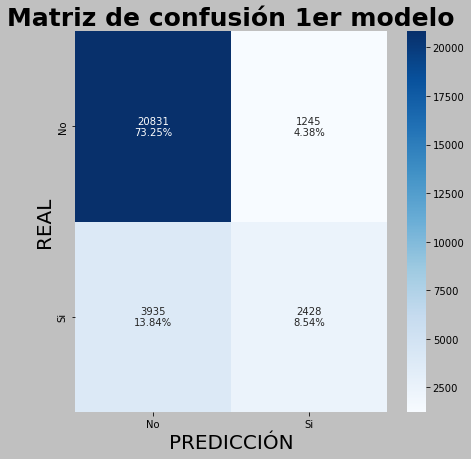

In [608]:
plt.figure(figsize=(7,7),facecolor= 'silver')
clases = ['No','Si']
group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión 1er modelo", fontsize=25, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=20)
plt.ylabel("REAL", fontsize=20)
plt.show()

#### De acuerdo a la matriz de confusión, el primer modelo de clasifición se obtiene la siguiente interpretación

- De acuerdo al modelo, este logró 22.076 predicciones correctas
- Por el contrario hubieron 5.180 que fueron incorrectas
- En 1.245 resultados arrojaron que que no llovia mañana, cuando en realidad si
- En 3.935 resultados arrojaron que que si llovia mañana, cuando en realidad no

Profundidad del árbol: 5
Número de nodos terminales: 32


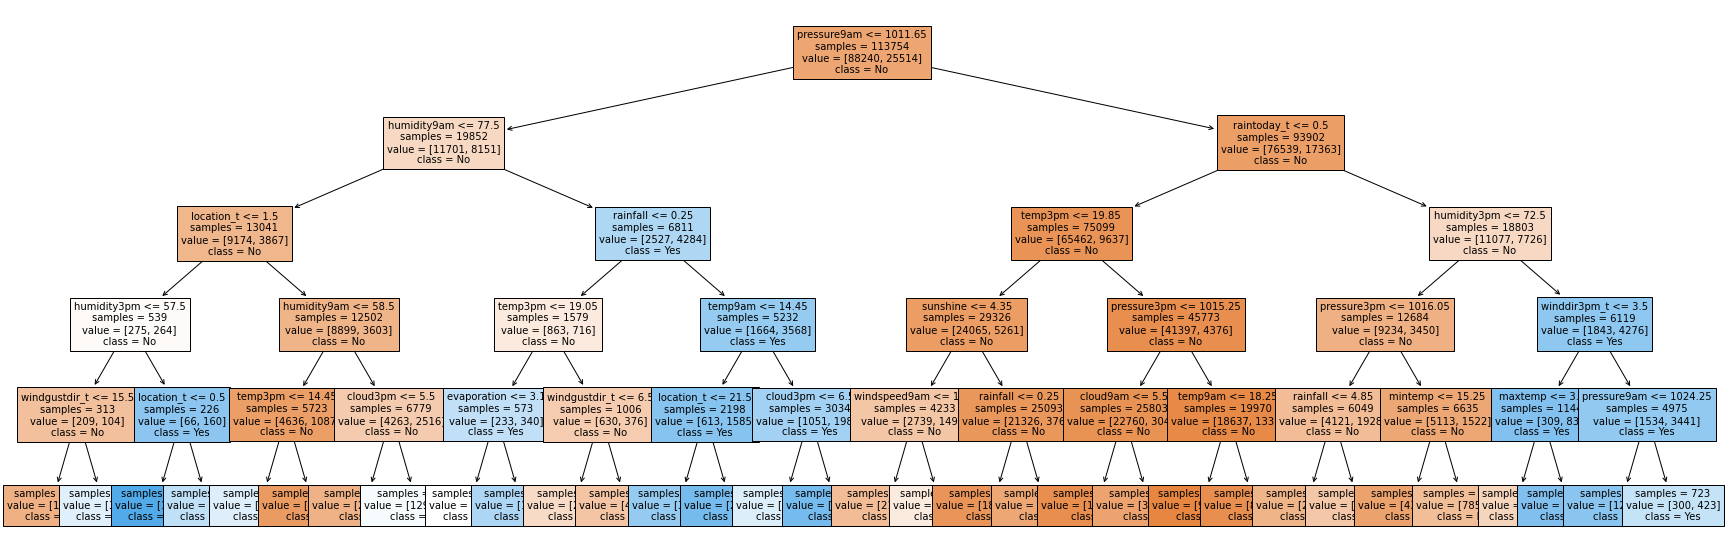

In [609]:
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(30, 10))

plot = plot_tree(
            decision_tree = modelo,
            feature_names = df_numeric.drop(columns = ["raintomorrow_t"]).columns,
            class_names   = ['No', 'Yes'],
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

### Mejorando el modelo (DecisionTree)


#### Preparación de los datos


In [610]:
df_importancia = pd.DataFrame(modelo.feature_importances_.reshape(-1, 1), 
                              index = modelo.feature_names_in_, columns = ['importancia'])
df_importancia.importancia.sort_values(ascending = False)

raintoday_t      0.288931
pressure9am      0.203163
humidity3pm      0.185401
humidity9am      0.143521
temp3pm          0.043326
sunshine         0.035853
cloud3pm         0.029186
rainfall         0.023161
cloud9am         0.013295
pressure3pm      0.013174
location_t       0.007065
temp9am          0.004960
windspeed9am     0.003487
mintemp          0.003103
windgustdir_t    0.001167
evaporation      0.000482
maxtemp          0.000398
winddir3pm_t     0.000327
windspeed3pm     0.000000
season_t         0.000000
windgustspeed    0.000000
winddir9am_t     0.000000
month            0.000000
Name: importancia, dtype: float64

In [611]:
features = df_importancia[df_importancia.importancia > 0].index

X_2 = df_numeric[features]
y_2 = df_numeric.raintomorrow_t

#### Creación, entrenamiento y prueba del modelo


In [612]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=29)

modelo_2 = DecisionTreeClassifier(random_state=29, max_depth=5)
modelo_2.fit(X_train_2, y_train_2)
y_pred_2 = modelo_2.predict(X_test_2)

In [613]:
print('Accuracy del modelo: %.2f' % accuracy_score(y_test_2, y_pred_2))
print('F1 score del modelo: %.2f' % f1_score(y_test_2, y_pred_2))
print('Recall del modelo: %.2f' % recall_score(y_test_2, y_pred_2))

print('Precisión del modelo: %.2f' % modelo_2.score(X_test_2, y_test_2))

precision_modelos.append( modelo_2.score(X_test_2, y_test_2))

Accuracy del modelo: 0.83
F1 score del modelo: 0.51
Recall del modelo: 0.39
Precisión del modelo: 0.83


In [614]:
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     22076
           1       0.74      0.39      0.51      6363

    accuracy                           0.83     28439
   macro avg       0.79      0.68      0.71     28439
weighted avg       0.82      0.83      0.81     28439



- **_Accurancy_** : Dio un 83%, esto dado que el modelo aprendió en su mayoria con valores 'No' de la variable raintomorrow, esto no nos da un resultado confiable
- **_F1_** : El promedio armónico de la precisión y la exhaustividad es de 51%
- **_Recall_** : El modelo ha sido capaz de precedir el 39% de los valores positivos (Yes)
- **_Precisión_** : El modelo tuvo un 83% de precisión

In [615]:
matriz_2 = confusion_matrix(y_test_2, y_pred_2)
print('Matriz de Confusión:')
print(matriz_2)

Matriz de Confusión:
[[21179   897]
 [ 3862  2501]]


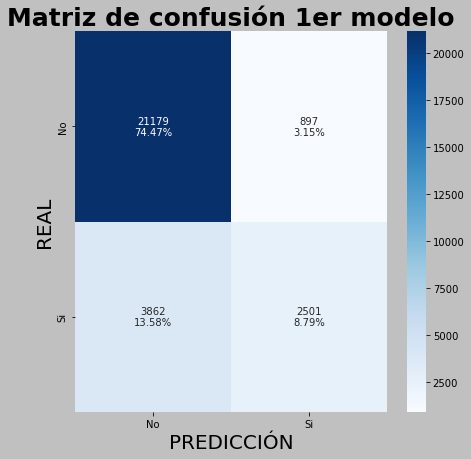

In [616]:
plt.figure(figsize=(7,7),facecolor= 'silver')
clases = ['No','Si']
group_counts = ["{0:0.0f}".format(value) for value in matriz_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matriz_2.flatten()/matriz_2.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_2, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión 1er modelo", fontsize=25, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=20)
plt.ylabel("REAL", fontsize=20)
plt.show()

#### De acuerdo a la matriz de confusión, el primer modelo de clasifición se obtiene la siguiente interpretación

- De acuerdo al modelo, este logró 23.680 predicciones correctas
- Por el contrario hubieron 4.759 que fueron incorrectas
- En 897 resultados arrojaron que que no llovia mañana, cuando en realidad si
- En 3.862 resultados arrojaron que que si llovia mañana, cuando en realidad no

Profundidad del árbol: 5
Número de nodos terminales: 32


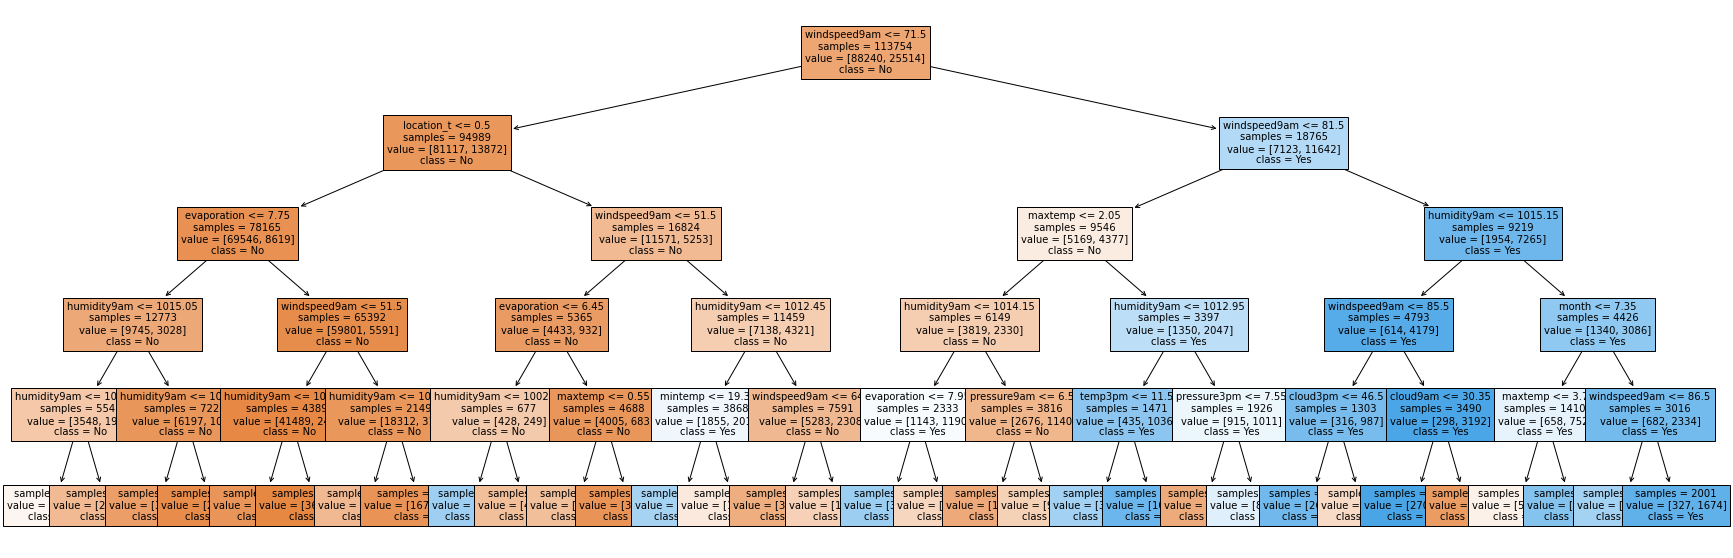

In [617]:
fig, ax = plt.subplots(figsize=(30, 10))

print(f"Profundidad del árbol: {modelo_2.get_depth()}")
print(f"Número de nodos terminales: {modelo_2.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo_2,
            feature_names = df_numeric.drop(columns = ["raintomorrow_t"]).columns,
            class_names   = ['No', 'Yes'],
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
        )

### Implementación usando algoritmo 2


#### Preparación de los datos


In [618]:
X_3 = df_numeric.drop(["raintomorrow_t"],axis=1)
y_3 = df_numeric.raintomorrow_t

#### Creación, entrenamiento y prueba del modelo


In [619]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state = 29)

modelo_3 = GaussianNB()
modelo_3.fit(X_train_3, y_train_3)

y_pred_3 = modelo_3.predict(X_test_3)

#### Evaluación del modelo


In [620]:
print('Accurancy del modelo:  %.2f' % accuracy_score(y_test_3, y_pred_3))
print('F1 score del modelo: %.2f' % f1_score(y_test_3, y_pred_3))
print('Recall del modelo: %.2f' % recall_score(y_test_3, y_pred_3))
precision_3 = precision_score(y_test_3, y_pred_3)
print('Precisión del modelo: %.2f' % precision_3)

precision_modelos.append(precision_score(y_test_3, y_pred_3))

Accurancy del modelo:  0.81
F1 score del modelo: 0.59
Recall del modelo: 0.62
Precisión del modelo: 0.56


In [621]:
raintomorrow_names = ['No', 'Yes']
print(classification_report(y_test_3, y_pred_3, target_names=raintomorrow_names))

              precision    recall  f1-score   support

          No       0.89      0.86      0.87     22076
         Yes       0.56      0.62      0.59      6363

    accuracy                           0.81     28439
   macro avg       0.72      0.74      0.73     28439
weighted avg       0.81      0.81      0.81     28439



- **_Accurancy_** : Dio un 81%, esto dado que el modelo aprendió en su mayoria con valores 'No' de la variable raintomorrow, esto no nos da un resultado confiable
- **_F1_** : El promedio armónico de la precisión y la exhaustividad es de 59%
- **_Recall_** : El modelo ha sido capaz de precedir un 62% de los valores positivos (Yes)
- **_Precisión_** : El modelo tuvo un 56% de precisión


In [622]:
matriz_3 = confusion_matrix(y_test_3, y_pred_3)
print('Matriz de Confusión:')
print(matriz_3)

Matriz de Confusión:
[[18995  3081]
 [ 2448  3915]]


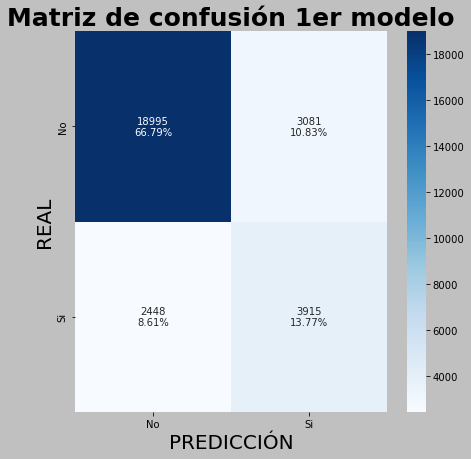

In [623]:
plt.figure(figsize=(7,7),facecolor= 'silver')
clases = ['No','Si']
group_counts = ["{0:0.0f}".format(value) for value in matriz_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matriz_3.flatten()/matriz_3.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_3, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión 1er modelo", fontsize=25, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=20)
plt.ylabel("REAL", fontsize=20)
plt.show()

#### De acuerdo a la matriz de confusión, el primer modelo de clasifición se obtiene la siguiente interpretación

- De acuerdo al modelo, este logró 22.891 predicciones correctas
- Por el contrario hubieron 5.548 que fueron incorrectas
- 3.173 resultados arrojaron que que no llovia mañana, cuando en realidad si
- 2.375 resultados arrojaron que que si llovia mañana, cuando en realidad no


### Mejorando el modelo (GaussianNB)


#### Preparación de los datos


In [648]:
X_4 = df_numeric[features]
y_4 = df_numeric.raintomorrow_t

#### Creación, entrenamiento y prueba del modelo


In [649]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state = 29)

modelo_4 = GaussianNB()
modelo_4.fit(X_train_4, y_train_4)
y_pred_4 = modelo_4.predict(X_test_4)

#### Evaluación del modelo


In [650]:
print('Accurancy del modelo:  %.2f' % accuracy_score(y_test_4, y_pred_4))
print('F1 score del modelo: %.2f' % f1_score(y_test_4, y_pred_4))
print('Recall del modelo: %.2f' % recall_score(y_test_4, y_pred_4))
precision_4 = precision_score(y_test_4, y_pred_4)
print('Precisión del modelo: %.2f' % precision_4)

precision_modelos.append(precision_score(y_test_4, y_pred_4))

Accurancy del modelo:  0.80
F1 score del modelo: 0.58
Recall del modelo: 0.61
Precisión del modelo: 0.56


In [651]:
print(classification_report(y_test_4, y_pred_4, target_names=raintomorrow_names))

              precision    recall  f1-score   support

          No       0.88      0.86      0.87     22076
         Yes       0.56      0.61      0.58      6363

    accuracy                           0.80     28439
   macro avg       0.72      0.73      0.73     28439
weighted avg       0.81      0.80      0.81     28439



- **_Accurancy_** : Dio un 80%, esto dado que el modelo aprendió en su mayoria con valores 'No' de la variable raintomorrow, esto no nos da un resultado confiable
- **_F1_** : El promedio armónico de la precisión y la exhaustividad es de 58%
- **_Recall_** : El modelo ha sido capaz de precedir el 61% de los valores positivos (Yes)
- **_Precisión_** : El modelo tuvo un 56% de precisión


In [652]:
matriz_4 = confusion_matrix(y_test_4, y_pred_4)
print('Matriz de Confusión:')
print(matriz_4)

Matriz de Confusión:
[[18997  3079]
 [ 2496  3867]]


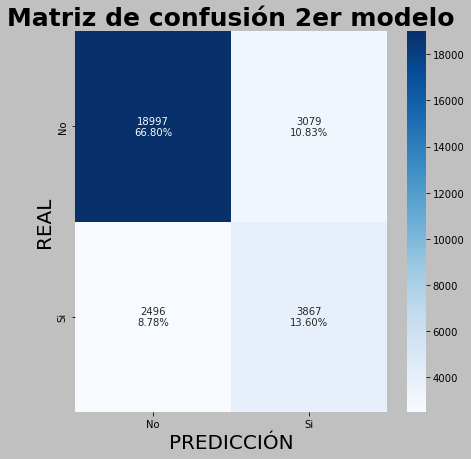

In [653]:
plt.figure(figsize=(7,7),facecolor= 'silver')
clases = ['No','Si']
group_counts = ["{0:0.0f}".format(value) for value in matriz_4.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matriz_4.flatten()/matriz_4.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matriz_4, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión 2er modelo", fontsize=25, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=20)
plt.ylabel("REAL", fontsize=20)
plt.show()

#### De acuerdo a la matriz de confusión, el primer modelo de clasifición se obtiene la siguiente interpretación

- De acuerdo al modelo, este logró 22.864 predicciones correctas
- Por el contrario hubieron 5.575 que fueron incorrectas
- En 3.079 resultados arrojaron que que no llovia mañana, cuando en realidad si
- En 2.496 resultados arrojaron que que si llovia mañana, cuando en realidad no


#### Mejora de modelo NB con SelectKBest

In [630]:
## Intentando mejorar el modelo 4 NB con SelectKBest
X_5 = df_numeric.drop(['raintomorrow_t'], axis=1) 
y_5 = df_numeric['raintomorrow_t']
best = SelectKBest(k=10)
X_new = best.fit_transform(X_5, y_5) 
selected = best.get_support(indices=True) 
print(X_5.columns[selected])

Index(['rainfall', 'sunshine', 'windgustspeed', 'humidity9am', 'humidity3pm',
       'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday_t'],
      dtype='object')


In [631]:
used_features = X_5.columns[selected]

X_5 = df_numeric[used_features]
# Se separan los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state = 29) 
modelo_5 = GaussianNB()
# Entrenamiento del modelo
modelo_5.fit(X_train_5, y_train_5)
# Validación del modelo
y_pred_5 = modelo_5.predict(X_test_5)

In [632]:
print('Precisión del modelo: %.2f' % precision_score(y_test_5, y_pred_5))
print('Accurancy del modelo: %.2f' % accuracy_score(y_test_5, y_pred_5))
print('F1 score del modelo: %.2f' % f1_score(y_test_5, y_pred_5))
print('Recall del modelo: %.2f' % recall_score(y_test_5, y_pred_5))

Precisión del modelo: 0.59
Accurancy del modelo: 0.81
F1 score del modelo: 0.58
Recall del modelo: 0.58


+ Al realizar este quinto modelo para intentar mejorar, se obtuvo una mejora minima de 1%
+ En este modelo se útilizaron las 10 variables con mayor correlación con raintomorrow_t, estas fueron seleccionadas con SelectKBest
+ Dado estos resultados, no se pudo obtener el 80% esperado

### Elección del mejor modelo

En esta sección deberá elegir el mejor modelo, jsutificando CLARAMENTE su elección


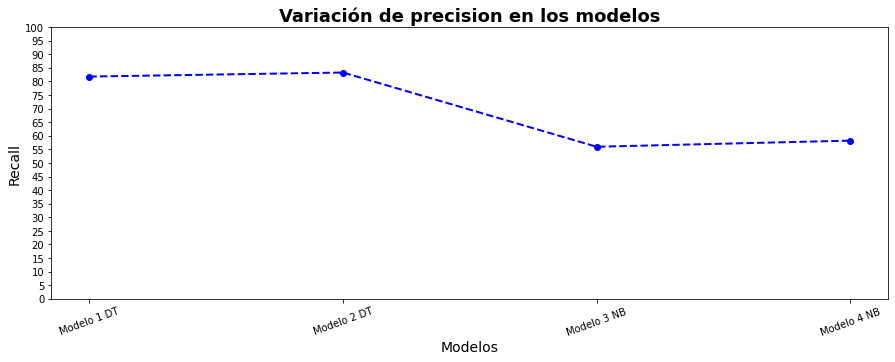

In [633]:
porcentaje = []

for i in precision_modelos:
    porcentaje.append(i*100)

plt.title("Variación de precision en los modelos", fontsize=18, fontweight="bold")
plt.xlabel("Modelos", fontsize=14); plt.ylabel("Recall", fontsize=14)
plt.xticks([0, 1, 2, 3], ['Modelo 1 DT', 'Modelo 2 DT','Modelo 3 NB', 'Modelo 4 NB'], rotation=20)
plt.plot(porcentaje, 'bo--', linewidth=2, markersize=6);
plt.yticks(range(0,105, 5));
plt.gcf().set_size_inches(15, 5)

### Uso del mejor modelo para realizar predicciones con datos independientes del conjunto de datos entregado


- Teniendo en cuenta que la precisión de los modelos realziados, se utilizarán los dos modelos con la mejor precisión, en este caso es el Modelo 2 DT y el Modelo 4 NB
- Estos modelos se realizaron con las mismas variables independientes, para realizar la comparación entre ambos
- Se aprecia la baja de precisión en los modelos de NB

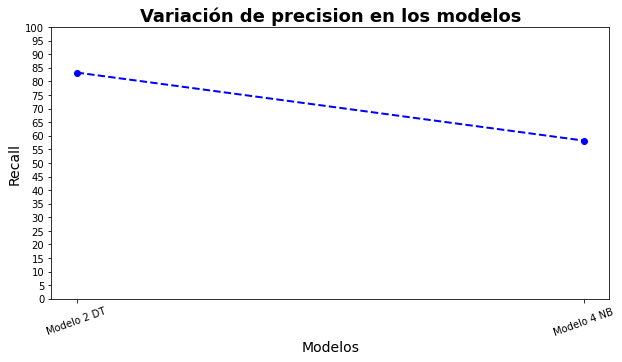

In [634]:
modelos_comparacion = [precision_modelos[1], precision_modelos[3]]
porcentajes_ = []

for i in modelos_comparacion:
    porcentajes_.append(i*100)

plt.title("Variación de precision en los modelos", fontsize=18, fontweight="bold")
plt.xlabel("Modelos", fontsize=14); plt.ylabel("Recall", fontsize=14)
plt.xticks([0, 1,], ['Modelo 2 DT', 'Modelo 4 NB'], rotation=20)
plt.plot(porcentajes_, 'bo--', linewidth=2, markersize=6);
plt.yticks(range(0,105, 5));
plt.gcf().set_size_inches(10, 5)

- En la visualización anterior, se observa que el Modelo 2 DT obtuvo la mejor precisión (84%) respecto al Modelo 4 NB (58%), es por esto que el modelo ha utilizar será el que tiene el mayor porcentaje de precisión


In [635]:
def findCity(city):
    city_num = {
        'Albury': 2, 'BadgerysCreek': 4, 'Cobar': 10, 'CoffsHarbour': 11, 'Moree': 21,
       'Newcastle': 24, 'NorahHead': 26, 'NorfolkIsland': 27, 'Penrith': 30, 'Richmond': 34,
       'Sydney': 37, 'SydneyAirport': 38, 'WaggaWagga': 42, 'Williamtown' : 45,
       'Wollongong': 47, 'Canberra': 9, 'Tuggeranong': 40, 'MountGinini': 23, 'Ballarat': 5,
       'Bendigo': 6, 'Sale': 35, 'MelbourneAirport': 19, 'Melbourne': 18, 'Mildura':20,
       'Nhil':25, 'Portland': 33, 'Watsonia':44, 'Dartmoor': 12, 'Brisbane': 7, 'Cairns' : 8,
       'GoldCoast' : 14, 'Townsville': 39, 'Adelaide' : 0, 'MountGambier' : 22, 'Nuriootpa' : 28,
       'Woomera': 48, 'Albany': 1, 'Witchcliffe': 46, 'PearceRAAF': 29, 'PerthAirport': 32,
       'Perth': 31, 'SalmonGums': 36, 'Walpole': 43, 'Hobart': 15, 'Launceston': 17,
       'AliceSprings': 3, 'Darwin': 13, 'Katherine': 16 , 'Uluru': 41 }
    
    return city_num.get(city)

def findWindDir(windDir):
    winddir_num = {
        'WSW': 15, 'WNW': 16, 'W': 13, 'SW': 12, 'SSW': 11, 'SSE': 10, 'SE': 9, 'S': 8, 'NW': 7, 'NNW': 6,
       'NNE': 5, 'NE': 4, 'N': 3, 'ESE':2, 'ENE': 1, 'E': 0}
    
    return winddir_num.get(windDir)

In [639]:
raintoday_t = input('Ingrese si es llovió el día de hoy')

raint = 0 if raintoday_t == 'No' else 1

pressure9am = input('Ingrese la presión a las 9am Ej: 1005.4')
humidity3pm = input('Ingrese su nivel de humedad a las 3pm Ej: 56.0')
humidity9am = input('Ingrese su nivel de humedad a las 9am Ej: 56.0')
temp3pm = input('Ingrese la temperatura a las 3pm Ej: 17.4')
sunshine = input('Ingrese el nivel de rayos solares Ej: 8.5')
cloud3pm = input('Ingrese el nivel nubocidad a las 3pm Ej: 7.0')

if raintoday_t == 'Si':
    rainfall = input('Ingresa la cantidad de lluvia caida Ej: 1.4')
else:
    rainfall = 0.0
    
cloud9am = input('Ingrese el nivel nubocidad a las 9am Ej: 7.0')   
pressure3pm = input('Ingrese la presión a las 3pm Ej: 1005.4')
location_t = input('Ingrese su ciudad')
temp9am = input('Ingrese la temperatura a las 9am Ej: 7.4')
windgustspeed = input('Ingrese la velocidad del viento Ej: 35.3')
windspeed9am = input('Ingrese la velocidad del viento a las 3pm Ej: 78.5')
mintemp = input('Ingrese la temperatura minima registrada Ej: 2.0')
windgustsdir_t = input('Ingrese la dirección del viento Ej: WSW, WNW, W, SW, SSW, SSE, SE, S, NW, NNW, NNE, NE, N ,ESE, ENE, E')
evaporation = input('Ingrese el nivel evaporation Ej: 4.8')
maxtemp = input('Ingrese la temperatura maxima registrada Ej: 27.0')
winddir3pm_t = input('Ingrese la dirección del viento a las 3pm Ej: WSW, WNW, W, SW, SSW, SSE, SE, S, NW, NNW, NNE, NE, N ,ESE, ENE, E')

In [640]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## Predicción con modelo 2
prediction = modelo_2.predict([[raint, float(pressure9am), float(humidity3pm), float(humidity9am), float(temp3pm), float(sunshine),float(cloud3pm), float(rainfall), float(pressure3pm), findCity(location_t.capitalize()), float(temp9am), float(windgustspeed), float(windspeed9am), float(mintemp), findWindDir(windgustsdir_t.upper()), float(evaporation), float(maxtemp), findWindDir(winddir3pm_t.upper())]])

result = 'No' if prediction == [0] else 'Si' 

In [641]:
if rainfall == 0:
    print('Si en la ciudad de {0} no llovió en el día, la humedad es de {1}(9am) y {2}(3pm), la presión es de {3}(9am) y {4}(3pm), la temperatura es de {5}(9am) y {6}(3pm), el nivel de rayos del sol es de {7}, el nivel de nubosidad es de {8}(9am) y {9}(3pm), la velocidad del viento es de {10}(9am), la temperatura minima es de {11}, la temperatura maxima es de {12}, la dirección del viento es de {13}, la dirección del viento a las 3pm es de {14}, el nivel de evaporación es de {15}, la velocidad del viento es de {16}'.format(location_t, humidity9am,humidity3pm, pressure9am, pressure3pm, temp9am, temp9am, sunshine, cloud9am, cloud3pm, windspeed9am, mintemp. maxtemp, windgustsdir_t.upper(), winddir3pm_t.upper(), evaporation, windgustspeed))
    
    print('Segun el modelo predictivo numero 2 (DesicionTree) {0} llueve el día de mañana'.format(result))
    
else:
    print('Si en la ciudad de {0} Si llovió en el día, los ml de lluvia caida es de {1}, la humedad es de {2}(9am) y {3}(3pm), la presión es de {4}(9am) y {5}(3pm), la temperatura es de {6}(9am) y {7}(3pm), el nivel de rayos del sol es de {8}, el nivel de nubosidad es de {9}(9am) y {10}(3pm), la velocidad del viento es de {11}(9am), la temperatura minima es de {12}, la temperatura maxima es de {13}, la dirección del viento es de {14}, la dirección del viento a las 3pm es de {15}, el nivel de evaporación es de {16}, la velocidad del viento es de {17}'.format(location_t, rainfall,humidity9am,humidity3pm, pressure9am, pressure3pm, temp9am, temp9am, sunshine, cloud9am, cloud3pm, windspeed9am, mintemp, maxtemp, windgustsdir_t.upper(), winddir3pm_t.upper(), evaporation, windgustspeed))
    
    print('Segun el modelo predictivo numero 2 (DesicionTree) {0} llueve el día de mañana'.format(result))

Si en la ciudad de Albury Si llovió en el día, los ml de lluvia caida es de 1.3, la humedad es de 45.7(9am) y 45.6(3pm), la presión es de 1002.3(9am) y 1004.5(3pm), la temperatura es de 5.6(9am) y 5.6(3pm), el nivel de rayos del sol es de 8.7, el nivel de nubosidad es de 7.6(9am) y 7.5(3pm), la velocidad del viento es de 78.4(9am), la temperatura minima es de 2.4, la temperatura maxima es de 16.7, la dirección del viento es de SW, la dirección del viento a las 3pm es de SW, el nivel de evaporación es de 4.7, la velocidad del viento es de 45.6
Segun el modelo predictivo numero 2 (DesicionTree) No llueve el día de mañana
